<a href="https://colab.research.google.com/github/javierdealba/inmobibot/blob/main/Avance5_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avence 5: Modelo Final
Javier de Alba Pérez

A01226046

Equipo 26

---






## Instalaciones

Aquí se instalan los paquetes necesarios para el funcionamiento del código

In [1]:
! pip install langchain langchain_community langchain_core langchain_openai fastembed chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

## Importaciones y funciones

Se importan las librerías y se extrae la API key de una variable de entorno.

In [4]:
import os
import pandas as pd

from typing import List
from datetime import datetime as dt
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

openai_api_key = os.getenv("OPENAI_API_KEY")

Se definen las funciones a utilizar en el cuerpo principal del código. Esto se hace basado en las encuestas realizadas a modo ciego sobre los modelos. Tras checar las preferencias de la gente, se eligió el mejor modelo, que fue el que incluye la versión más reciente de Open AI, siendo el modelo gpt-4o.

In [5]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Loads data from a CSV file.

    This function reads a CSV file from the specified file path and
    returns the data as a pandas DataFrame.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    pd.DataFrame: A DataFrame containing the loaded data.
    """
    data = pd.read_csv(file_path)
    return data

def load_csv_with_loader():
    """
    Loads data from a CSV file using a CSVLoader.

    Returns:
        Any: The data loaded from the CSV file.
    """
    loader = CSVLoader(file_path="docs.csv", source_column="page_content", encoding="utf8")
    data = loader.load()

    return data


def create_documents(data: pd.DataFrame, data_columns: List[str]) -> pd.DataFrame:
    """
    Creates a new DataFrame containing concatenated string representations of
    selected columns from the input data, then saves it to a CSV file.

    Args:
        data (DataFrame): The input DataFrame containing the data.
        data_columns (List[str]): A list of column names from the input DataFrame to be included in the documents.

    Returns:
        DataFrame: A new DataFrame containing the concatenated documents.
    """
    data["page_content"] = ""
    for column in data_columns:
        data["page_content"] += f"{column}: " + data[column].astype(str) + "\n"

    docs = data[["page_content"]]
    docs.to_csv("docs.csv")

    return docs


def get_retriever(docs: pd.DataFrame):
    """
    Create a retriever for a given set of documents.

    Args:
        docs (pd.DataFrame): The DataFrame containing the documents.

    Returns:
        Retriever: The retriever object.
    """
    current_path = os.getcwd()
    data_path = os.path.join(current_path, "data/embeddings_vector_store")

    embedding_model = FastEmbedEmbeddings()
    vector_store = Chroma.from_documents(
        documents = docs,
        embedding = embedding_model,
        persist_directory = data_path,
    )

    retriever = vector_store.as_retriever(
        search_type = "similarity_score_threshold",
        search_kwargs = {
            "k": 20,
            "score_threshold": 0.05,
        },
    )
    print(retriever)

    return retriever


def generate_response(retriever, input_line: str) -> str:
    """
    Generate a response to an input question using the given retriever.

    Args:
        retriever: The retriever component used for document retrieval.
        input_line (str): The input question or query.

    Returns:
        str: The response to the input question.
    """
    template = """
    Compórtate como un excelente vendedor inmobiliario, por lo que las respuestas deben ser
    Contesta la pregunta que se hace basandote unicamente en el contexto que se proporciona.

    <context>
    {context}
    </context>

    Pregunta: {input}
    """
    model = ChatOpenAI(
        temperature=0.7, openai_api_key=openai_api_key, model="gpt-4o"
    )
    prompt = ChatPromptTemplate.from_template(template)


    document_chain = create_stuff_documents_chain(model, prompt)
    retrieval_chain = create_retrieval_chain(retriever, document_chain)
    response = retrieval_chain.invoke({"input": input_line})

    return response

Función principal (main), donde se entrena el modelo RAG.

In [7]:
data = load_data("listado_propiedades.csv")
data_columns = data.columns.tolist()
docs = create_documents(data, data_columns)
docs = load_csv_with_loader()


retriever = get_retriever(docs)

questions = [
    "¿Qué propiedades están disponibles en Capital Norte?",
    "¿Cuáles son las características de la propiedad ubicada en Toren54?",
    "¿Qué características tienen las propiedades en Santa Cruz de la Loma?",
    "¿Cuál es el rango de precios de las propiedades en Capital Norte?",
    "Quiero recibir información sobre la plaza comercial en venta en golfo de cortés.",
    "¿Qué amenidades están disponibles en las propiedades de Altavista?",
    "Busco una propiedad con un precio alrededor de $2,000,000 de pesos con 3 recámaras. ¿Qué opciones tienes?",
    "¿En qué zonas tienes terrenos con un tamaño mayor a 200 metros cuadrados?",
    "¿En dónde tienes departamentos en venta?",
    "¿Cuál es el mejor local comercial que tienes?",
]

def execution_function():
  start = dt.utcnow()
  responses = []
  for i, q in enumerate(questions):
    response = generate_response(retriever, q)
    responses.append(response)
    print(f"Pregunta {i+1}: {q}")
    print(f"\nRespuesta:\n{response['answer']}\n\n")
  end = dt.utcnow()

  print(f"Elapsed time = {end-start}")

execution_function()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

tags=['Chroma', 'FastEmbedEmbeddings'] vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7fd73e976bf0> search_type='similarity_score_threshold' search_kwargs={'k': 20, 'score_threshold': 0.05}
Pregunta 1: ¿Qué propiedades están disponibles en Capital Norte?

Respuesta:
¡Claro! En Capital Norte tenemos varias opciones de propiedades disponibles para ti:

1. **Capital Norte Coto Sienna**
    - **Dirección:** Paseo de la Cantera 702 Casa 28, Col. Sendas residencial, Zapopan, Jalisco
    - **Tipo de propiedad:** Casa
    - **Niveles:** 3
    - **Recámaras:** 3
    - **Baños:** 2 completos y 1 medio baño
    - **Estacionamientos:** 2
    - **Terreno:** 112 m²
    - **Construcción:** 163 m²
    - **Precio:** $3,900,000
    - **Mantenimiento:** $1,200
    - **Estado:** Excelente
    - **Antigüedad:** Nueva

2. **Capital Norte Coto Sivec 73**
    - **Dirección:** Av. D 575 73, Col. Sendas residencial, Zapopan, Jalisco
    - **Tipo de propiedad:** Casa
    - **Niveles:** 3

Los resultados de la encuesta fueron los siguientes, y de la misma manera se adjunta el [documento de Excel](https://github.com/javierdealba/inmobibot/blob/main/resultados_encuesta.xlsx) que genera la [encuesta de Google Forms](https://docs.google.com/forms/d/1Y7bWDgkewmjZrOh_-Rmhw_vgKriwN6zyvBL2bLBHjSU/edit#responses). Dentro de esta encuesta hay veces que se repetía la respuesta, por lo que hay preguntas que tienen menos de 4 opciones. Estas 4 opciones se tomaros de los mejores 4 modelos, de los 6 propuestos, esto tras checar si se contestaban de manera correcta, incorrecta o parcial las preguntas. Estos resultados están en la primera tabla, junto con sus tiempos de ejecución. 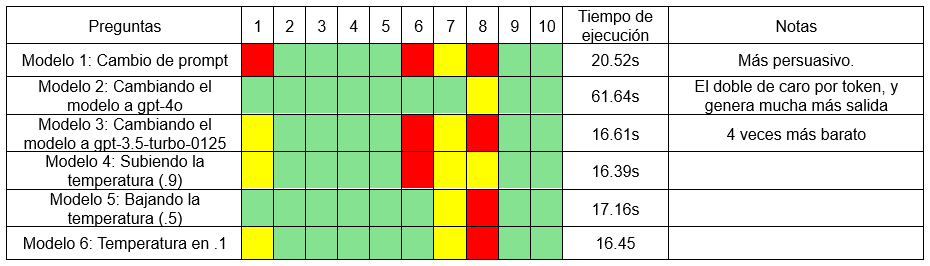

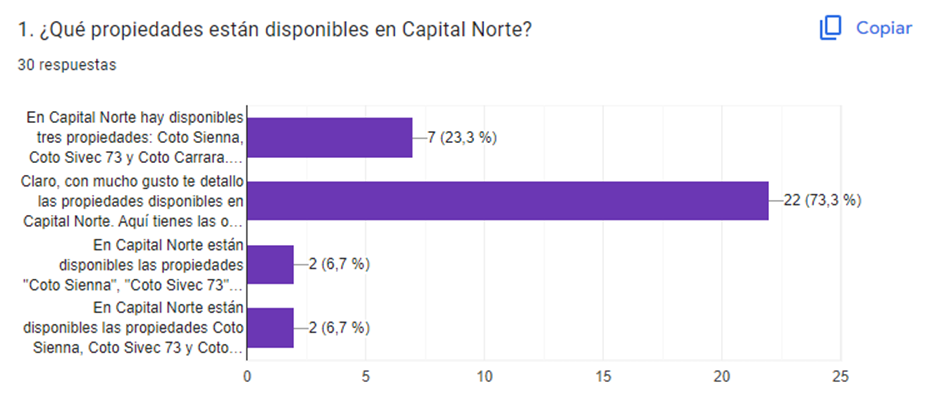

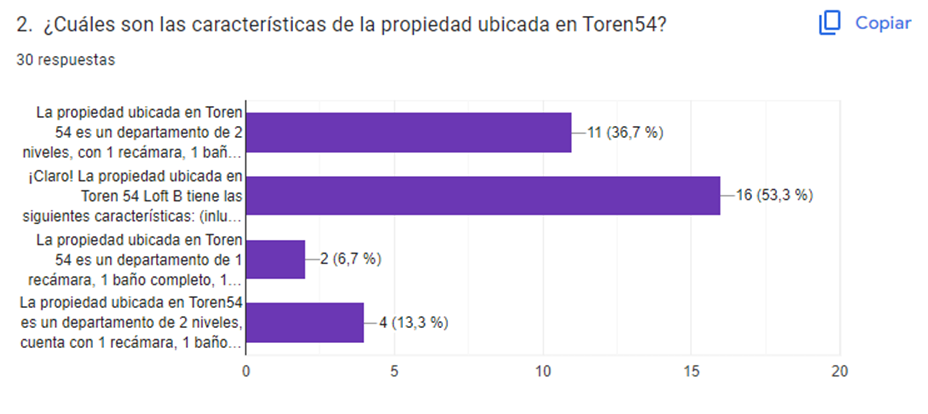
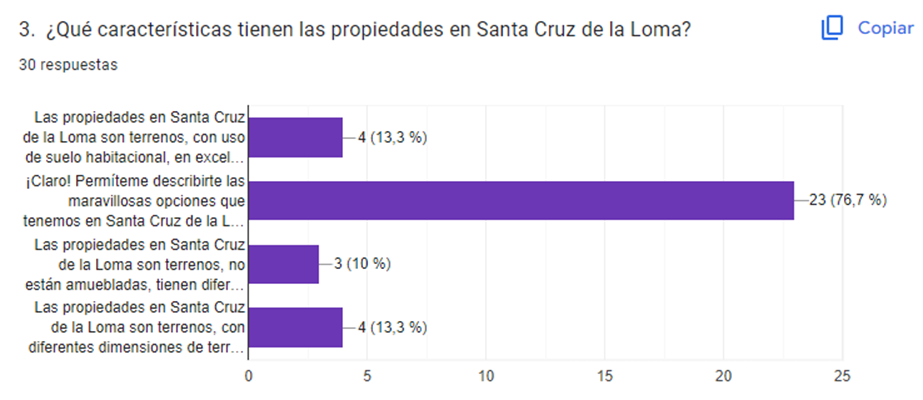
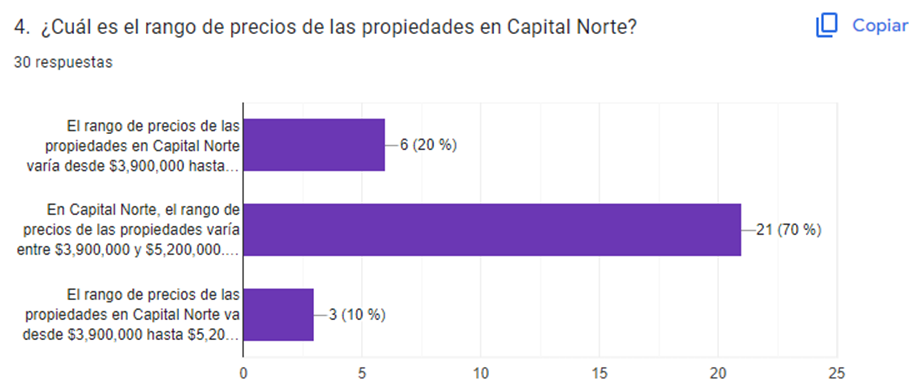
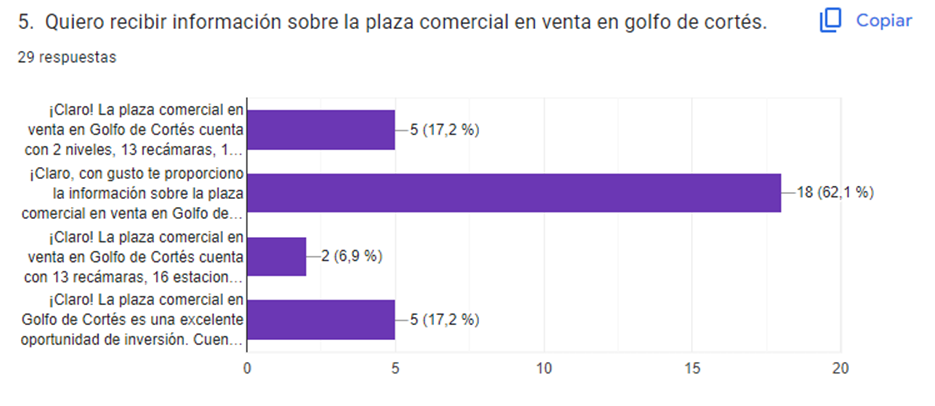
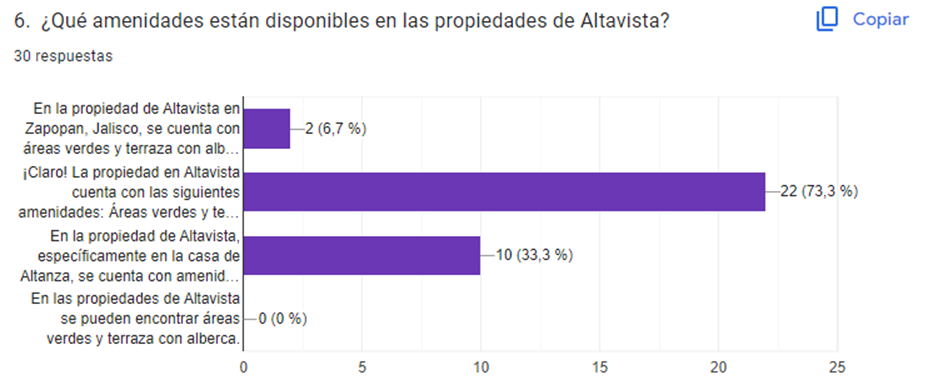
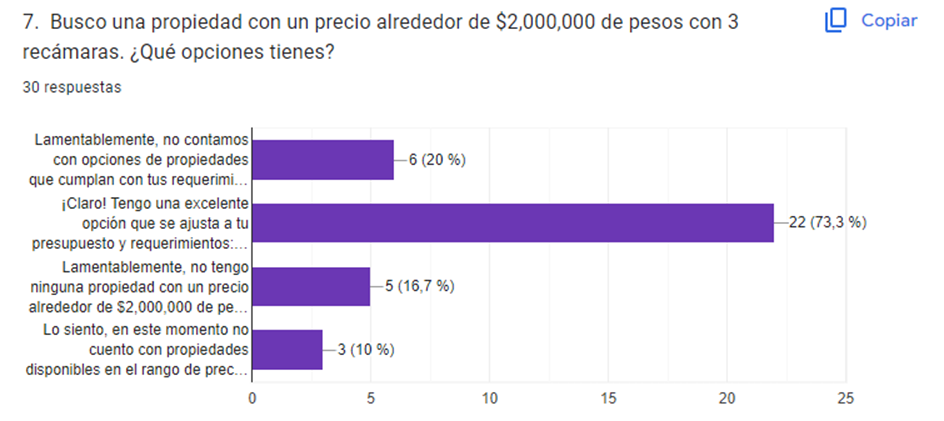
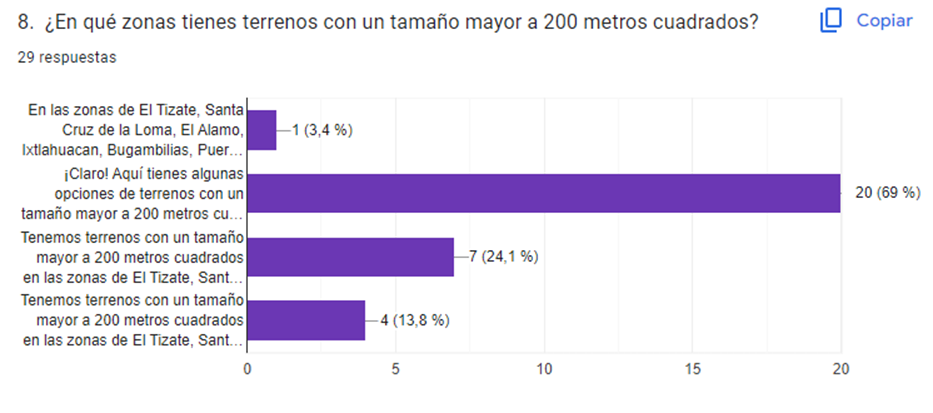
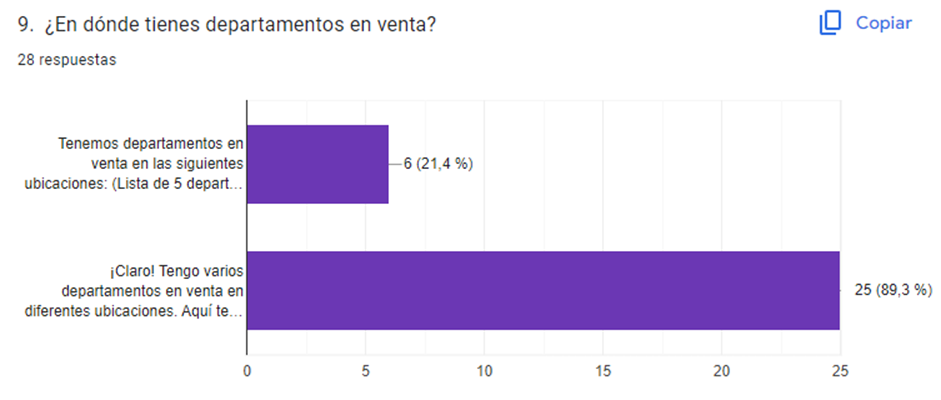
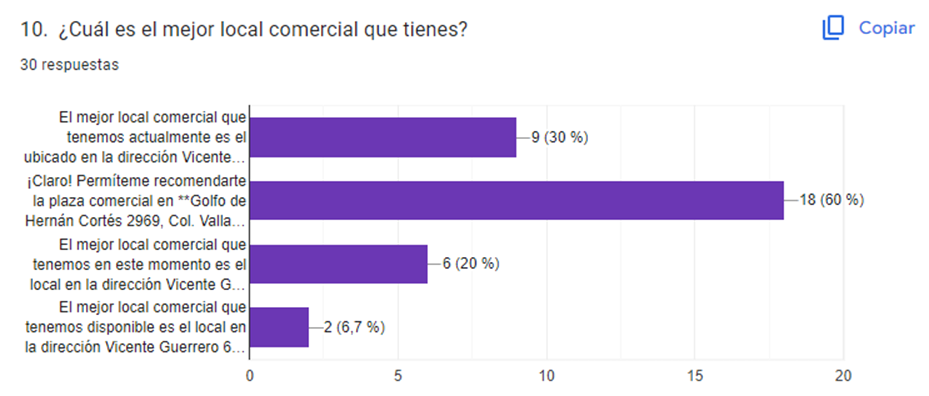